<a href="https://colab.research.google.com/github/Gousepasha789/Tea-Leaf-disease-detection/blob/main/teaLeaf_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Step 2: Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/teaLeafBD_processed"

print(f"Dataset Path: {base_path}")

Mounted at /content/drive
Dataset Path: /content/drive/MyDrive/teaLeafBD_processed


In [3]:
# Step 3: Data Preprocessing
IMAGE_SIZE = (96, 96)
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Data loaded successfully!")

Found 4222 images belonging to 7 classes.
Found 1053 images belonging to 7 classes.
Data loaded successfully!


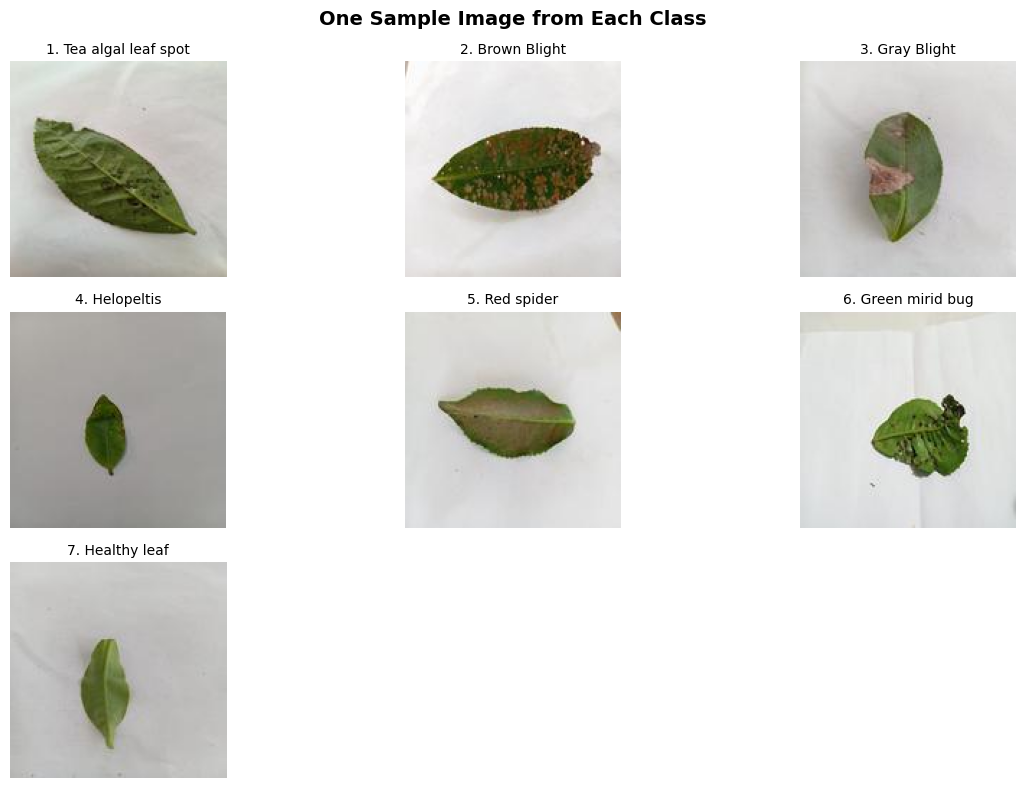

In [4]:
# Step 4: Display one sample image from each class
class_labels = list(train_data.class_indices.keys())

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_labels):
    # Get one image from each class folder directly
    class_dir = os.path.join(base_path, class_name)
    sample_image = os.listdir(class_dir)[0]  # pick first image
    img_path = os.path.join(class_dir, sample_image)

    img = plt.imread(img_path)

    plt.subplot(3, 3, i+1)  # adjust if more/less than 9 classes
    plt.imshow(img)
    plt.title(class_name, fontsize=10)
    plt.axis("off")

plt.suptitle("One Sample Image from Each Class", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
# Step 5: Build Transfer Learning Model (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2

num_classes = train_data.num_classes

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False  # freeze base layers initially

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Step 6: Train the CNN Model

checkpoint = ModelCheckpoint("best_tealeaf_model.keras",
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=1,
                              min_lr=1e-6,
                              verbose=1)

print("Starting CNN Training...")

EPOCHS = 15

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

Starting CNN Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3479 - loss: 1.8712
Epoch 1: val_accuracy improved from -inf to 0.59259, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 1448s 5s/step - accuracy: 0.3482 - loss: 1.8701 - val_accuracy: 0.5926 - val_loss: 1.0864 - learning_rate: 1.0000e-04
Epoch 2/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5926 - loss: 1.1608
Epoch 2: val_accuracy improved from 0.59259 to 0.64103, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 61s 231ms/step - accuracy: 0.5927 - loss: 1.1607 - val_accuracy: 0.6410 - val_loss: 0.9835 - learning_rate: 1.0000e-04
Epoch 3/15
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6503 - loss: 1.0027
Epoch 3: val_accuracy improved from 0.64103 to 0.70180, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 59s 225ms/step - accuracy: 0.6503 - loss: 1.0027 - val_accuracy: 0.7018 - val_loss: 0.9018 - learning_rate: 1.0000e-04
Epoch 4/

Loading best model for evaluation...
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6515 - loss: 1.0276
Final Validation Accuracy: 72.65%

Training & Evaluation Complete!
Total Epochs Run : 15


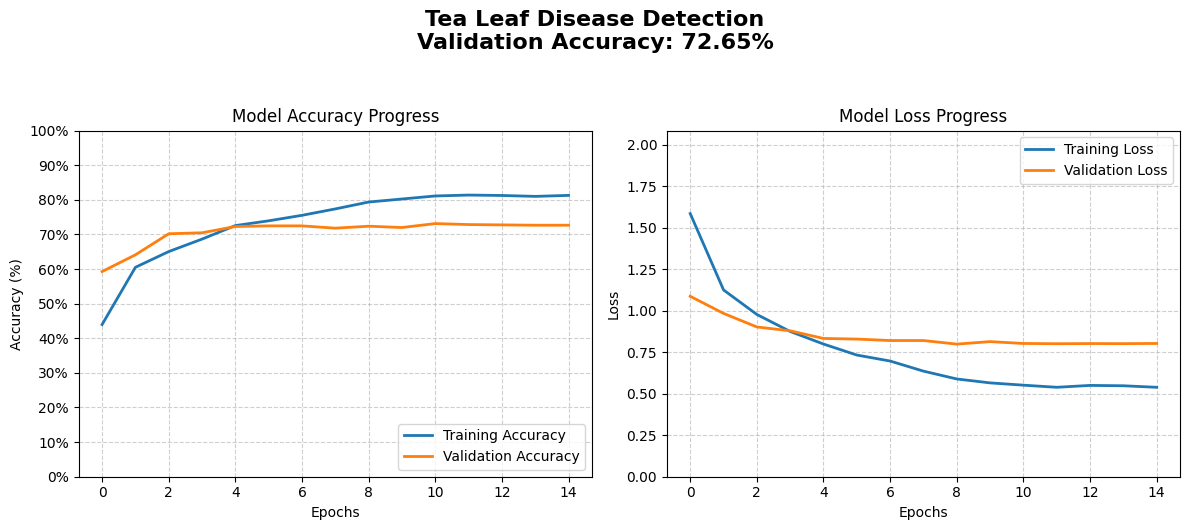

In [10]:
# Step 7: Evaluate Model & Visualize Training

# Final evaluation
print("Loading best model for evaluation...")
best_model = tf.keras.models.load_model("best_tealeaf_model.keras")

loss, acc = model.evaluate(val_data)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

print("\nTraining & Evaluation Complete!")
print(f"Total Epochs Run : {len(history.history['accuracy'])}")

# Plot training history
plt.figure(figsize=(12,5))

plt.suptitle(f"Tea Leaf Disease Detection\nValidation Accuracy: {acc*100:.2f}%",
             fontsize=16, fontweight='bold', y=1.05)

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1.0)  # 🔹 Force 0–1 scale
plt.yticks(np.linspace(0, 1.0, 11), [f"{int(x*100)}%" for x in np.linspace(0, 1.0, 11)])
plt.legend(loc='lower right')
plt.title('Model Accuracy Progress')
plt.grid(True, linestyle='--', alpha=0.6)
plt.box(True)

# Loss subplot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
plt.ylim(0, max_loss + 0.5)  # auto adjust but starts at 0
plt.legend(loc='upper right')
plt.title('Model Loss Progress')
plt.grid(True, linestyle='--', alpha=0.6)
plt.box(True)

plt.tight_layout()
plt.show()

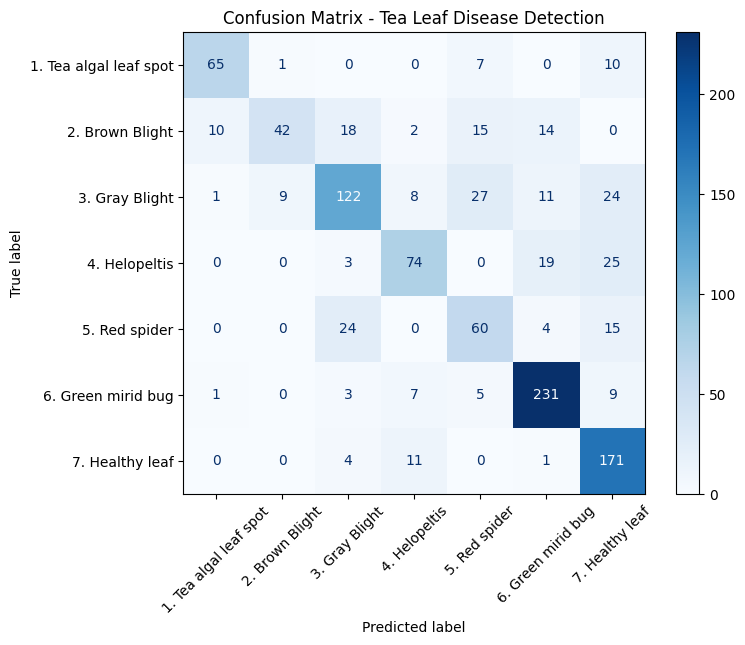

In [11]:
# Get true labels directly from val_data
y_true = val_data.labels

# Predict in one batch
y_pred = np.argmax(model.predict(val_data, verbose=0), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", values_format="d", xticks_rotation=45, ax=plt.gca())
plt.title("Confusion Matrix - Tea Leaf Disease Detection")
plt.show()

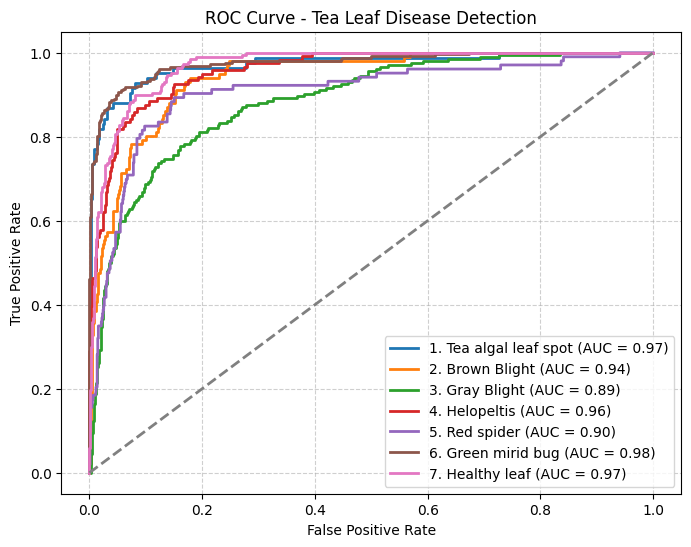

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# True labels
y_true = val_data.labels

# Predict probabilities
y_pred_prob = best_model.predict(val_data, verbose=0)

# Binarize labels for multi-class ROC
n_classes = len(val_data.class_indices)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(8,6))

# Plot ROC for each class
for i in range(n_classes):
    # Check if there are positive samples for the current class
    if np.sum(y_true_bin[:, i]) > 0:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{list(val_data.class_indices.keys())[i]} (AUC = {roc_auc:.2f})")
    else:
        print(f"Skipping ROC plot for class {list(val_data.class_indices.keys())[i]} due to no positive samples in validation data.")


# Random guess line
plt.plot([0,1], [0,1], color="gray", lw=2, linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tea Leaf Disease Detection")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()